# Multi-Experiment Method Comparison

Compare multiple similarity methods across different datasets and experiment runs:
- **Cross-dataset comparison**: How do methods perform on different datasets?
- **Dataset difficulty**: Which datasets are more challenging?
- **Method rankings**: Which methods perform best overall and per-dataset?
- **Per-dataset correlation**: Do methods agree on query difficulty within each dataset?

## Configuration Options

**Option 1 - Auto-scan** (recommended): Provide a top-level directory and automatically discover all experiments
```python
AUTO_SCAN = True
EXPERIMENT_BASE_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline"
```

**Option 2 - Manual list**: Specify exact experiment directories
```python
AUTO_SCAN = False
EXPERIMENT_DIRS = [
    PROJECT_ROOT / "outputs" / "run1",
    PROJECT_ROOT / "outputs" / "run2"
]
```

In [19]:
# === Imports ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
sys.path.append(r'D:\sim-bench')

from sim_bench.analysis.utils import get_project_root
from sim_bench.analysis.multi_experiment import load_experiments
from sim_bench.analysis.export import export_notebook_to_pdf, archive_notebook

# Try to import fivecentplots for advanced box plots
try:
    import fivecentplots as fcp
    HAVE_FCP = True
except ImportError:
    HAVE_FCP = False
    print("⚠️  fivecentplots not installed. Using matplotlib/seaborn for plots.")
    print("   Install with: pip install fivecentplots")

sns.set_style('whitegrid')
warnings.filterwarnings('always', category=UserWarning)  # Show duplicate warnings

## Configuration

In [20]:
# === Configuration ===
PROJECT_ROOT = get_project_root()

# Choose scanning mode
AUTO_SCAN = True

if AUTO_SCAN:
    # Option 1: Auto-scan from base directory
    EXPERIMENT_BASE_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" 
    EXPERIMENT_DIRS = None
else:
    # Option 2: Manual list of experiment directories
    EXPERIMENT_BASE_DIR = None
    EXPERIMENT_DIRS = [
        PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-24_01-10-45",
        PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-27_00-40-09"
    ]

# === Output Options ===
EXPORT_PDF = True  # Export entire notebook to PDF

print(f"Scanning mode: {'AUTO' if AUTO_SCAN else 'MANUAL'}")
if AUTO_SCAN:
    print(f"Base directory: {EXPERIMENT_BASE_DIR.relative_to(PROJECT_ROOT)}")
else:
    print(f"Manual directories: {len(EXPERIMENT_DIRS)} specified")

Scanning mode: AUTO
Base directory: outputs\baseline_runs\comprehensive_baseline


## 1. Load Data

In [21]:
# Load all experiment data
metrics_df, per_query_dict, experiment_infos = load_experiments(
    base_dir=EXPERIMENT_BASE_DIR,
    experiment_dirs=EXPERIMENT_DIRS,
    auto_scan=AUTO_SCAN,
    verbose=True
)

print(f"\n{'='*80}")
print("DATA SUMMARY")
print(f"{'='*80}")
print(f"Total combinations: {len(metrics_df)}")
print(f"Methods: {sorted(metrics_df['method'].unique())}")
print(f"Datasets: {sorted(metrics_df['dataset'].unique())}")
print(f"\nDataFrame shape: {metrics_df.shape}")
print(f"\nAvailable metrics: {[c for c in metrics_df.columns if c not in ['method', 'dataset', 'run_name', 'created_at']]}")

Scanning: D:\sim-bench\outputs\baseline_runs\comprehensive_baseline
  Found: deep on ukbench in 2025-11-02_00-11-58
  Found: deep on holidays in 2025-11-02_00-12-26
  Found: emd on ukbench in 2025-11-02_00-12-31
  Found: emd on holidays in 2025-11-02_10-38-24
  Found: sift_bovw on ukbench in 2025-11-02_10-52-06
  Found: sift_bovw on holidays in 2025-11-02_10-52-34
  Found: dinov2 on ukbench in 2025-11-02_10-52-38
  Found: dinov2 on holidays in 2025-11-02_10-53-06
  Found: openclip on ukbench in 2025-11-02_10-53-11
  Found: openclip on holidays in 2025-11-02_10-53-39

[OK] Found 10 method-dataset combinations
  holidays: 5 methods (deep, dinov2, emd, openclip, sift_bovw)
  ukbench: 5 methods (deep, dinov2, emd, openclip, sift_bovw)
[OK] Loaded: deep            on ukbench    - 10 metrics
[OK] Loaded: deep            on holidays   - 9 metrics
[OK] Loaded: emd             on ukbench    - 10 metrics
[OK] Loaded: emd             on holidays   - 9 metrics
[OK] Loaded: sift_bovw       on ukben

In [22]:
metrics_df.head()

method       map    map@10  ns_score  recall@10  num_queries  \
0       deep  0.945790  0.946336  2.828627   0.997745        10200   
1       deep  0.832074  0.820291       NaN   1.000000         1491   
2        emd  0.262920  0.264658  0.844804   0.616961        10200   
3        emd  0.244536  0.225233       NaN   1.000000         1491   
4  sift_bovw  0.498648  0.500233  1.522059   0.783922        10200   

   num_gallery                  created_at   dataset             run_name  
0        10200  2025-11-06T22:18:23.879114   ukbench  2025-11-02_00-11-58  
1         1491  2025-11-06T21:47:28.978403  holidays  2025-11-02_00-12-26  
2        10200  2025-11-06T22:19:01.579826   ukbench  2025-11-02_00-12-31  
3         1491  2025-11-06T21:47:28.999730  holidays  2025-11-02_10-38-24  
4        10200  2025-11-06T22:19:39.438126   ukbench  2025-11-02_10-52-06

In [23]:
# Display loaded data
display(metrics_df[['method', 'dataset', 'map', 'map@10', 'recall@10', 'map@10']].sort_values(['dataset', 'method']))

method   dataset       map    map@10  recall@10    map@10
1       deep  holidays  0.832074  0.820291   1.000000  0.820291
7     dinov2  holidays  0.892791  0.884979   1.000000  0.884979
3        emd  holidays  0.244536  0.225233   1.000000  0.225233
9   openclip  holidays  0.869491  0.860666   1.000000  0.860666
5  sift_bovw  holidays  0.384749  0.367859   1.000000  0.367859
0       deep   ukbench  0.945790  0.946336   0.997745  0.946336
6     dinov2   ukbench  0.957681  0.958185   0.997843  0.958185
2        emd   ukbench  0.262920  0.264658   0.616961  0.264658
8   openclip   ukbench  0.946145  0.946694   0.996373  0.946694
4  sift_bovw   ukbench  0.498648  0.500233   0.783922  0.500233

## 2. Per-Dataset Method Comparison

In [24]:
# Key metrics for comparison
key_metrics = ['recall@1', 'recall@10', 'map@10', 'map']
available_metrics = [m for m in key_metrics if m in metrics_df.columns]

# Create comparison tables per dataset
datasets = sorted(metrics_df['dataset'].unique())

for dataset in datasets:
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset.upper()}")
    print(f"{'='*80}")
    
    df_dataset = metrics_df[metrics_df['dataset'] == dataset].copy()
    df_comparison = df_dataset[['method'] + available_metrics].set_index('method')
    
    # Rank methods
    df_ranks = df_comparison.rank(ascending=False, method='min').astype(int)
    df_ranks['avg_rank'] = df_ranks.mean(axis=1)
    df_ranks = df_ranks.sort_values('avg_rank')
    
    print(f"\nMethod Performance:")
    display(df_comparison.style.highlight_max(axis=0, color='green'))
    
    print(f"\nMethod Rankings (1=best):")
    display(df_ranks)


DATASET: HOLIDAYS

Method Performance:



Method Rankings (1=best):


recall@10  map@10  map  avg_rank
method                                     
dinov2             1       1    1  1.000000
openclip           1       2    2  1.666667
deep               1       3    3  2.333333
sift_bovw          1       4    4  3.000000
emd                1       5    5  3.666667


DATASET: UKBENCH

Method Performance:



Method Rankings (1=best):


recall@10  map@10  map  avg_rank
method                                     
dinov2             1       1    1  1.000000
openclip           3       2    2  2.333333
deep               2       3    3  2.666667
sift_bovw          4       4    4  4.000000
emd                5       5    5  5.000000

## 3. Cross-Dataset Performance Comparison

In [25]:
# Pivot table: methods × datasets for key metric
pivot_metric = 'map@10'  # Change this to compare different metrics

if pivot_metric in metrics_df.columns:
    pivot_table = metrics_df.pivot_table(
        index='method',
        columns='dataset',
        values=pivot_metric,
        aggfunc='first'  # Take first if duplicates (shouldn't happen with warning)
    )
    
    print(f"\n{'='*80}")
    print(f"CROSS-DATASET COMPARISON: {pivot_metric.upper()}")
    print(f"{'='*80}\n")
    display(pivot_table.style.highlight_max(axis=0, color='green'))
    
    # Dataset difficulty (average performance across methods)
    dataset_difficulty = pivot_table.mean(axis=0).sort_values(ascending=False)
    print(f"\nDataset Difficulty (avg {pivot_metric} across all methods):")
    print("Higher = Easier dataset")
    display(dataset_difficulty.to_frame(name=f'avg_{pivot_metric}'))


CROSS-DATASET COMPARISON: MAP@10




Dataset Difficulty (avg map@10 across all methods):
Higher = Easier dataset


avg_map@10
dataset             
ukbench     0.723221
holidays    0.631806

## 4. Visualizations

### 4.1 Bar Charts: Per-Dataset Method Comparison

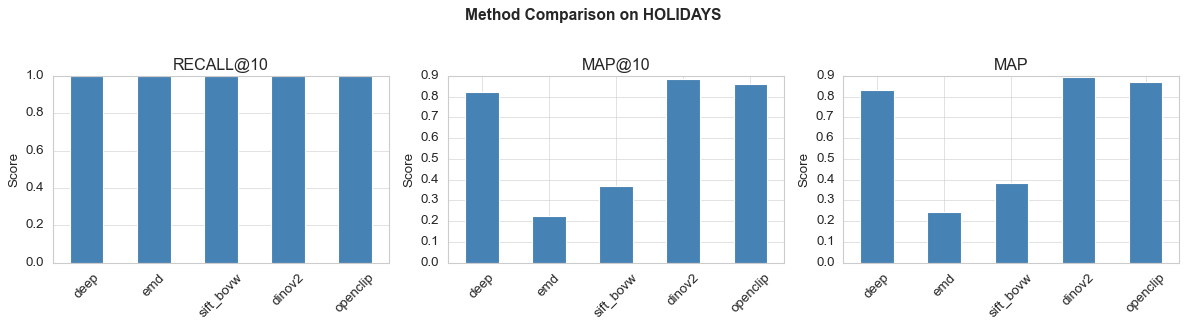

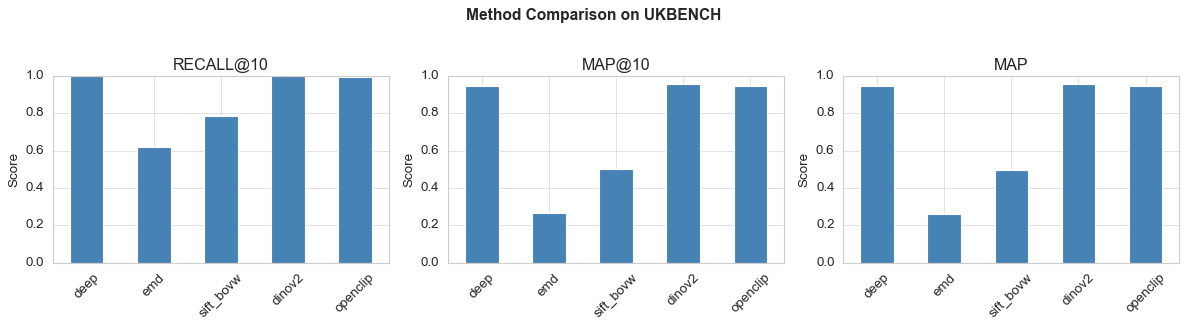

In [26]:
# Bar charts for each dataset
for dataset in datasets:
    df_dataset = metrics_df[metrics_df['dataset'] == dataset]
    
    n_metrics = min(4, len(available_metrics))
    fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]
    
    for idx, metric in enumerate(available_metrics[:n_metrics]):
        ax = axes[idx]
        df_dataset.plot(x='method', y=metric, kind='bar', ax=ax, color='steelblue', legend=False)
        ax.set_title(f'{metric.upper()}')
        ax.set_ylabel('Score')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'Method Comparison on {dataset.upper()}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 4.2 Box Plots: Per-Query Metric Distributions


BOX PLOT: AP@10 Distribution (using fivecentplots)



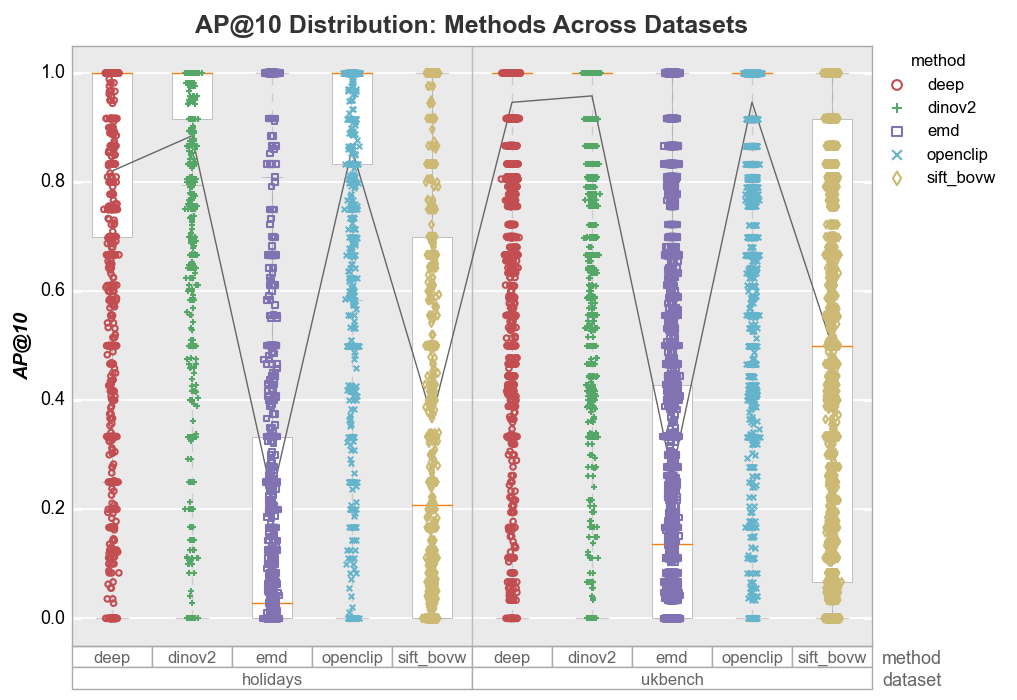


AP@10 Statistics:
Method          Dataset             Mean   Median      Std
------------------------------------------------------------
deep            holidays          0.8203   1.0000   0.2952
deep            ukbench           0.9463   1.0000   0.1519
dinov2          holidays          0.8850   1.0000   0.2403
dinov2          ukbench           0.9582   1.0000   0.1310
emd             holidays          0.2252   0.0278   0.3293
emd             ukbench           0.2647   0.1361   0.3074
openclip        holidays          0.8607   1.0000   0.2651
openclip        ukbench           0.9467   1.0000   0.1550
sift_bovw       holidays          0.3679   0.2083   0.3911
sift_bovw       ukbench           0.5002   0.5000   0.3881


In [27]:
# Box plots using fivecentplots if available, otherwise matplotlib
compare_metric = 'ap@10'

if compare_metric in next(iter(per_query_dict.values())).columns:
    # Prepare data for plotting
    plot_data = []
    for (method, dataset), df in per_query_dict.items():
        for value in df[compare_metric].values:
            plot_data.append({
                'method': method,
                'dataset': dataset,
                'value': value
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    if HAVE_FCP:
        # Use fivecentplots for advanced grouped box plots
        print(f"\n{'='*80}")
        print(f"BOX PLOT: {compare_metric.upper()} Distribution (using fivecentplots)")
        print(f"{'='*80}\n")
        
        fcp.boxplot(
            df_plot,
            groups=['dataset', 'method'],
            y='value',
            legend='method',
            ax_size=[800, 600],
            label_x='Dataset',
            label_y=compare_metric.upper(),
            title=f'{compare_metric.upper()} Distribution: Methods Across Datasets'
        )
    else:
        # Fallback to seaborn
        print(f"\n{'='*80}")
        print(f"BOX PLOT: {compare_metric.upper()} Distribution (using seaborn)")
        print(f"{'='*80}\n")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.boxplot(data=df_plot, x='dataset', y='value', hue='method', ax=ax)
        ax.set_xlabel('Dataset', fontsize=12)
        ax.set_ylabel(compare_metric.upper(), fontsize=12)
        ax.set_title(f'{compare_metric.upper()} Distribution: Methods Across Datasets', fontsize=14, fontweight='bold')
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    # Print statistics
    print(f"\n{compare_metric.upper()} Statistics:")
    print(f"{'Method':<15} {'Dataset':<15} {'Mean':>8} {'Median':>8} {'Std':>8}")
    print("-" * 60)
    for (method, dataset), df in sorted(per_query_dict.items()):
        values = df[compare_metric].values
        print(f"{method:<15} {dataset:<15} {values.mean():>8.4f} {np.median(values):>8.4f} {values.std():>8.4f}")
else:
    print(f"⚠️  Metric '{compare_metric}' not found in per-query data")

## 5. Per-Dataset Correlation Analysis

Shows if methods agree on which queries are difficult within each dataset.


CORRELATION MATRIX: HOLIDAYS (ap@10)
High correlation = methods agree on query difficulty



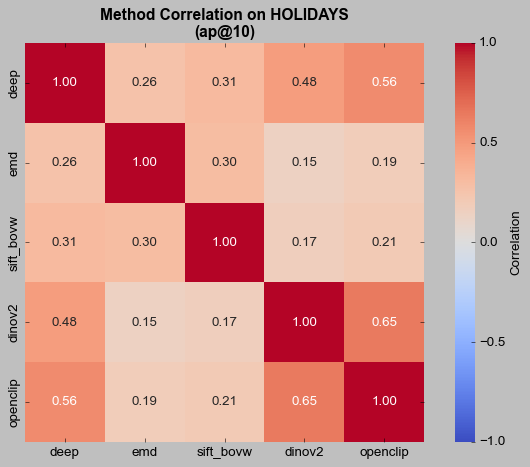


CORRELATION MATRIX: UKBENCH (ap@10)
High correlation = methods agree on query difficulty



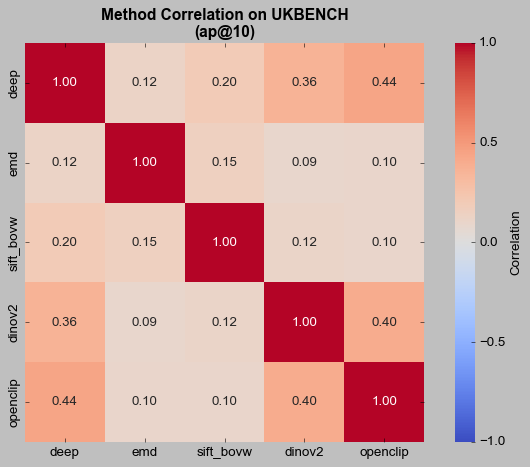

In [28]:
# Correlation analysis per dataset
for dataset in datasets:
    # Get methods for this dataset
    dataset_methods = [m for (m, d) in per_query_dict.keys() if d == dataset]
    
    if len(dataset_methods) < 2:
        print(f"\n⚠️  {dataset}: Only {len(dataset_methods)} method(s), skipping correlation")
        continue
    
    # Build correlation matrix
    df_corr = pd.DataFrame()
    for method in dataset_methods:
        key = (method, dataset)
        if key in per_query_dict and compare_metric in per_query_dict[key].columns:
            df_corr[method] = per_query_dict[key][compare_metric].values
    
    if len(df_corr.columns) >= 2:
        corr_matrix = df_corr.corr()
        
        print(f"\n{'='*80}")
        print(f"CORRELATION MATRIX: {dataset.upper()} ({compare_metric})")
        print(f"{'='*80}")
        print("High correlation = methods agree on query difficulty\n")
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
        plt.title(f'Method Correlation on {dataset.upper()}\n({compare_metric})', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

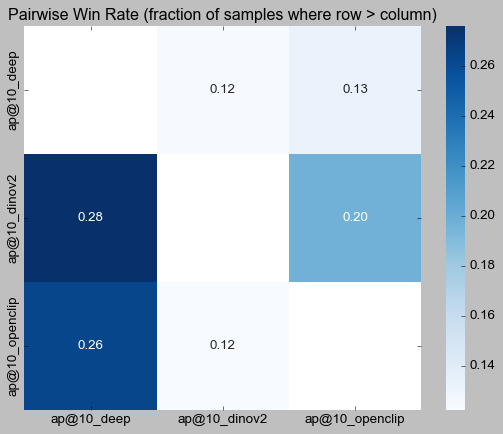

In [38]:
import pandas as pd
import numpy as np

methods = ['ap@10_deep', 'ap@10_dinov2', 'ap@10_openclip']
win_matrix = pd.DataFrame(index=methods, columns=methods, dtype=float)

for a in methods:
    for b in methods:
        if a == b:
            win_matrix.loc[a, b] = np.nan
        else:
            win_matrix.loc[a, b] = (df_merged_results[a] > df_merged_results[b]).mean()

sns.heatmap(win_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Pairwise Win Rate (fraction of samples where row > column)")
plt.show()


## 6. Method-Specific Wins Analysis

This section uses the new comparison functions to find and visualize queries where each method excels but others fail.

In [29]:
# Optional: Force reload of modules if they were recently updated
import sys
modules_to_clear = ['sim_bench.analysis.multi_experiment', 'sim_bench.analysis.comparison_viz']
for module_name in modules_to_clear:
    if module_name in sys.modules:
        del sys.modules[module_name]
        
print("Module cache cleared (if needed). Importing functions...")

Module cache cleared (if needed). Importing functions...


**Note:** If you get an ImportError, restart the Jupyter kernel (Kernel → Restart Kernel) and re-run from the beginning. This is needed because the comparison functions were recently added.

In [30]:
## 7. Summary

## 8. Export to PDF (Optional)

### 6.2 Find Method Wins

Find queries where each method performs well (≥0.9) but competitors fail (≤0.3):

### 6.1 Merge Per-Query Metrics

Using the new `merge_per_query_metrics()` function to combine metrics from multiple methods:


DEEP wins (3 queries):
 query_idx  ap@10_deep  ap@10_dinov2  ap@10_openclip
       580         1.0      0.000000             0.0
       116         1.0      0.142857             0.0
      1452         1.0      0.142857             0.0

DINOV2 wins (3 queries):
 query_idx  ap@10_dinov2  ap@10_deep  ap@10_openclip
       548           1.0    0.000000        0.000000
      1393           1.0    0.000000        0.071429
       856           1.0    0.111111        0.000000

OPENCLIP wins (3 queries):
 query_idx  ap@10_openclip  ap@10_deep  ap@10_dinov2
       455            1.00    0.000000      0.000000
      1322            1.00    0.100000      0.111111
      1307            0.95    0.193056      0.112500

DEEP: 3 winning queries


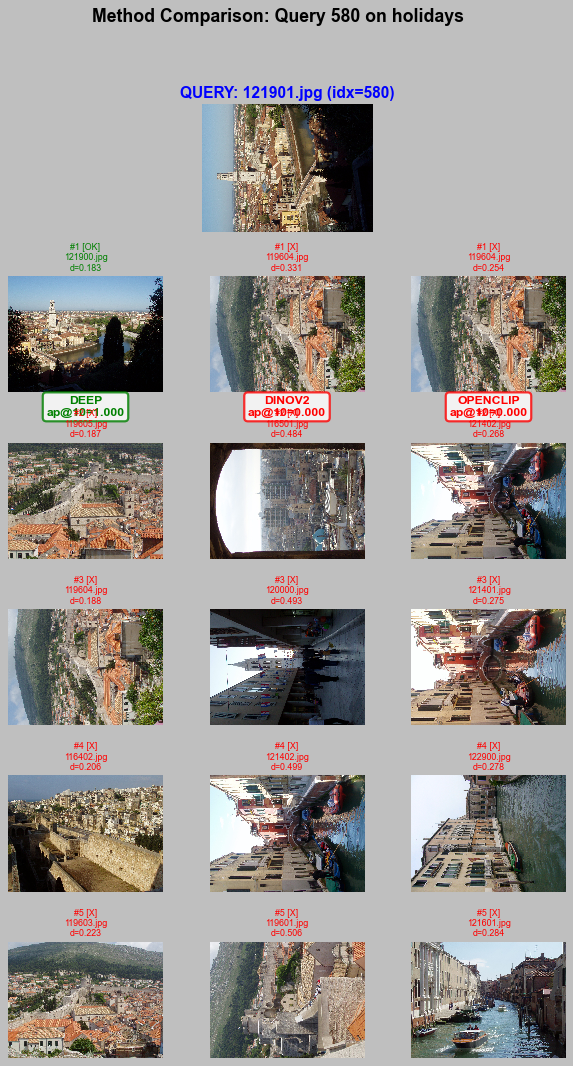

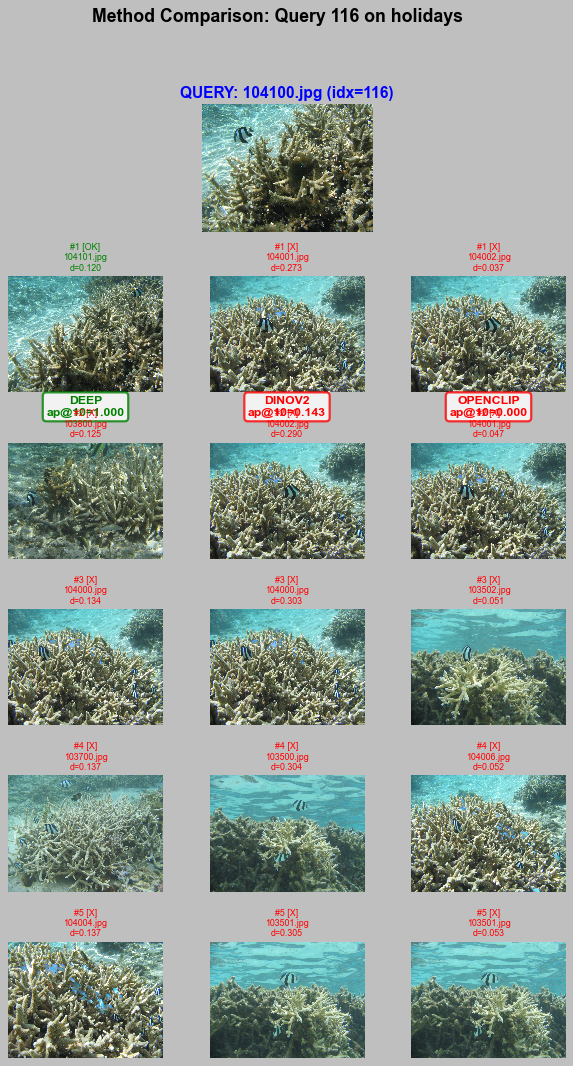

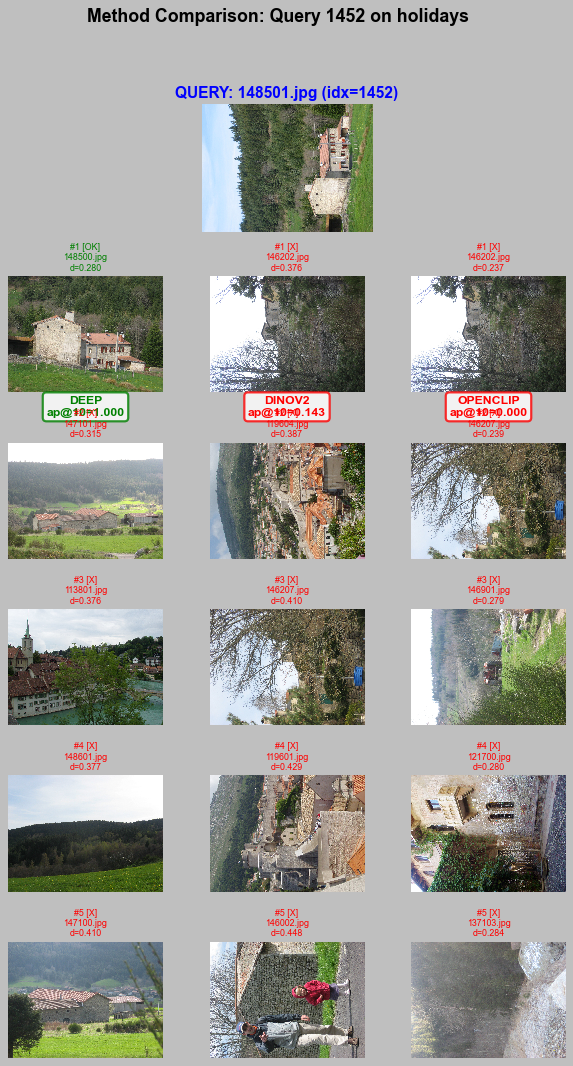


DINOV2: 3 winning queries


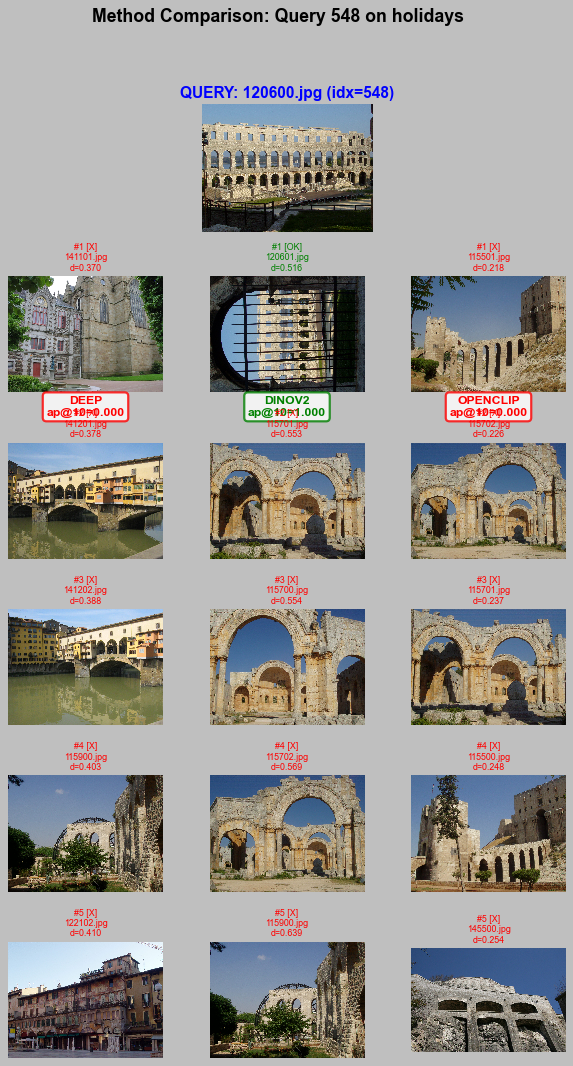

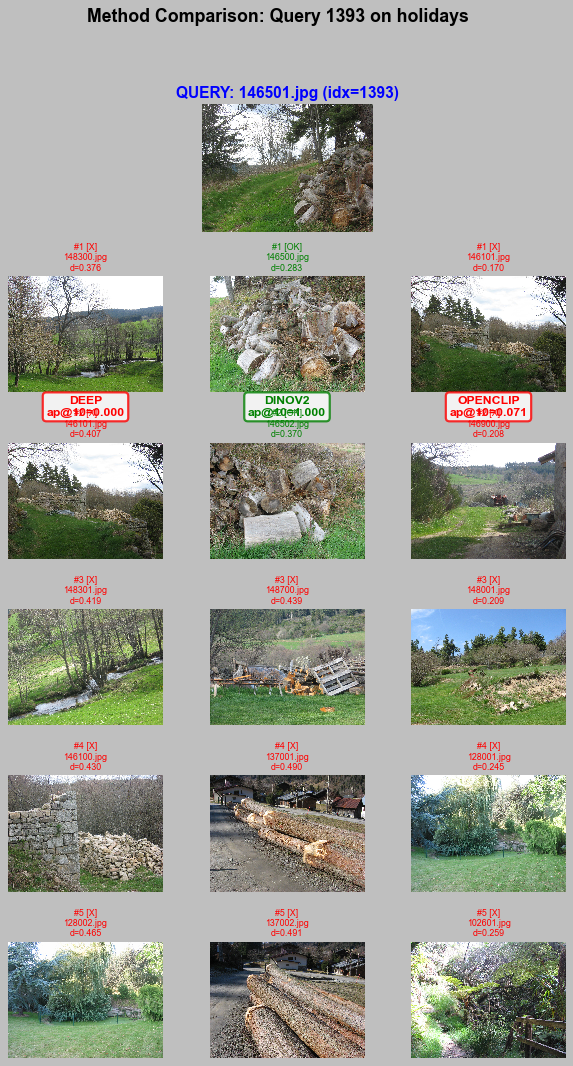

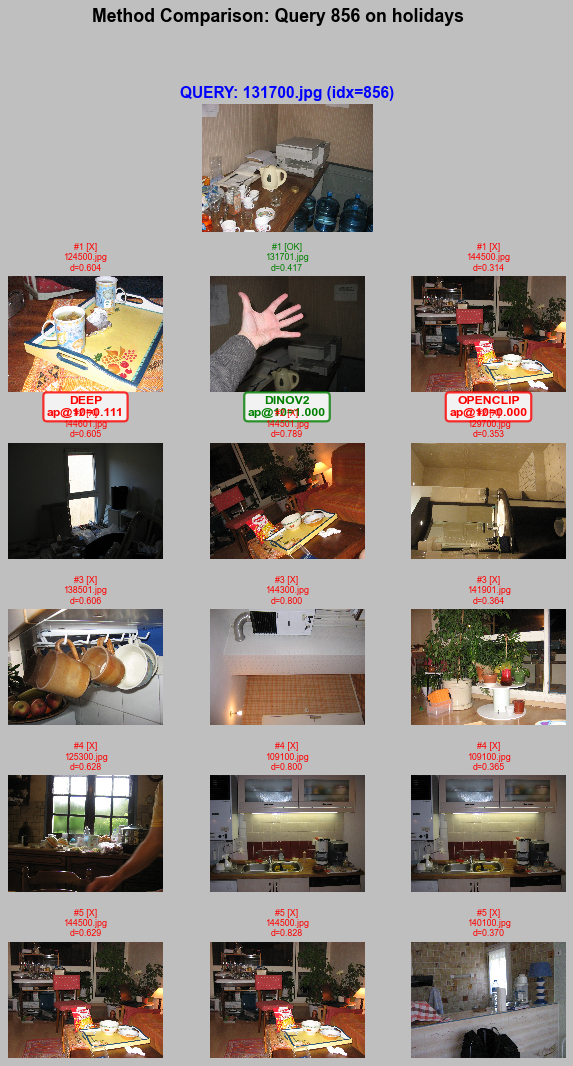


OPENCLIP: 3 winning queries


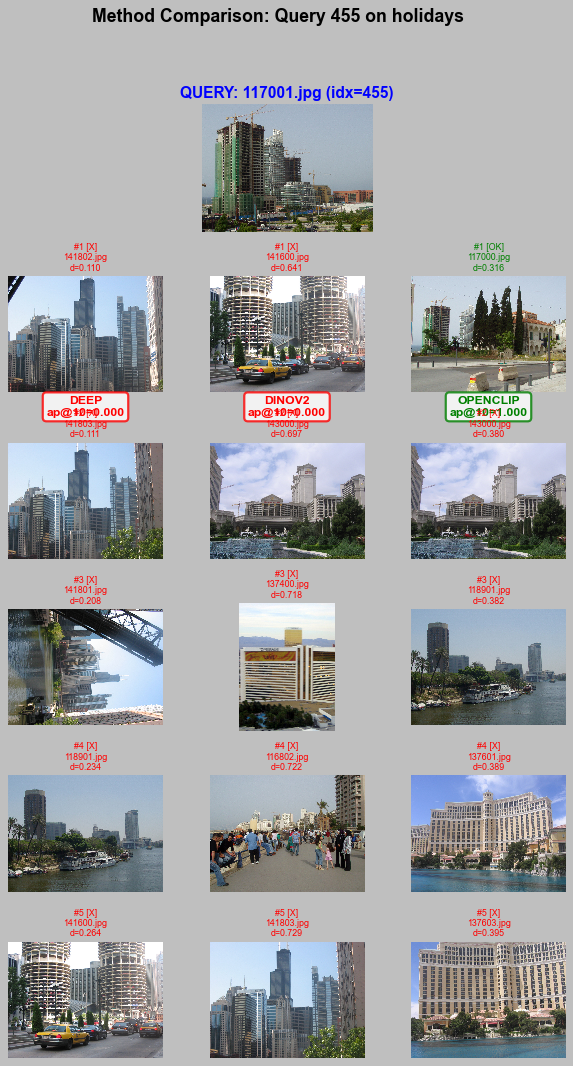

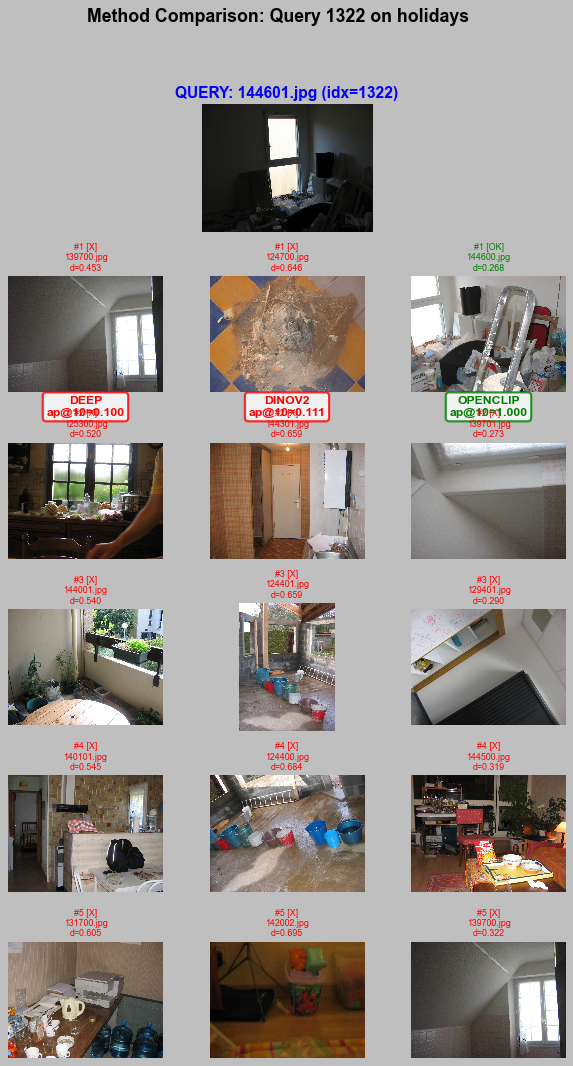

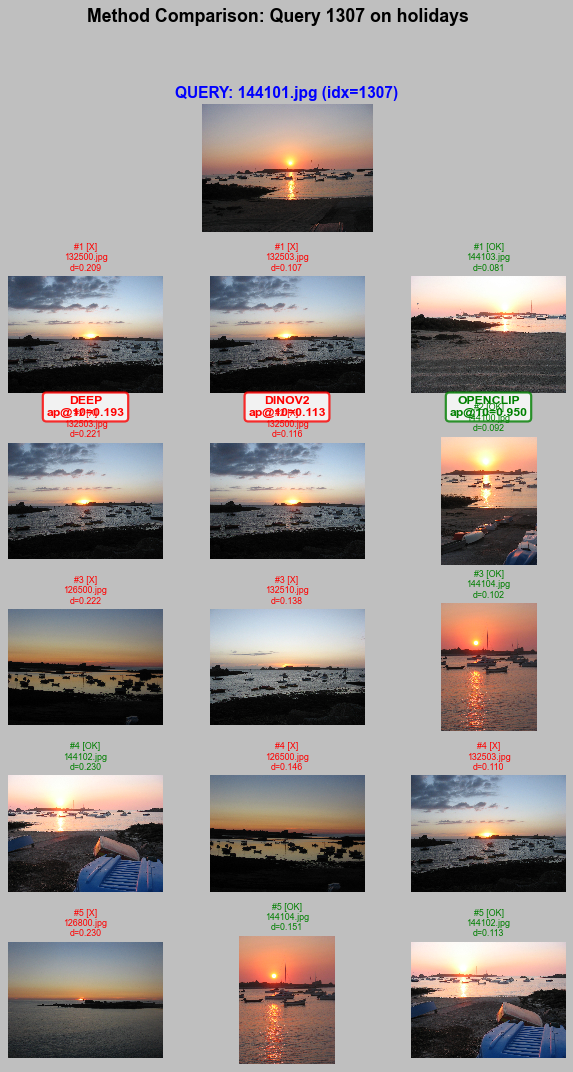


✓ Generated 9 comparison figures


In [37]:
from pathlib import Path
from sim_bench.analysis.multi_experiment import merge_per_query_metrics, find_all_method_wins
from sim_bench.analysis.comparison_viz import visualize_all_method_wins

# 1. Configuration
DATASET_CONFIG = {
    'name': 'holidays',
    'root': 'D:/Similar Images/DataSets/InriaHolidaysFull',
    'pattern': '*.jpg'
}

# 2. Find experiment directory from loaded data
holidays_experiment_dir = None
for info in experiment_infos:
    if info['dataset'] == 'holidays':
        holidays_experiment_dir = info['experiment_dir']
        break

# 3. Merge metrics
df_merged = merge_per_query_metrics(
    per_query_dict, 
    ['deep', 'dinov2', 'openclip'], 
    'holidays', 
    ['ap@10']
)

# 4. Find wins
all_wins = find_all_method_wins(
    df_merged, 
    ['deep', 'dinov2', 'openclip'], 
    'ap@10',
    threshold_high=0.9,
    threshold_low=0.3,
    top_n=3
)

# 5. Visualize - plots will appear in the notebook!
OUTPUT_DIR = holidays_experiment_dir / "analysis_reports" / "method_comparison_wins"

saved_figs = visualize_all_method_wins(
    all_wins, 
    ['deep', 'dinov2', 'openclip'], 
    'ap@10', 
    'holidays', 
    DATASET_CONFIG, 
    experiment_infos,  # ← CORRECT: Pass the experiment_infos list
    OUTPUT_DIR,
    top_n=5,
    show_plots=True
)

## Export to PDF (Optional)

In [36]:
# === Export to PDF and Archive Notebook (Optional) ===
if EXPORT_PDF:
    notebook_path = PROJECT_ROOT / "sim_bench" / "analysis" / "methods_comparison.ipynb"
    
    # Use first experiment dir for output location
    if AUTO_SCAN:
        output_dir = EXPERIMENT_BASE_DIR / "analysis_reports"
    else:
        output_dir = EXPERIMENT_DIRS[0] / "analysis_reports"
    
    # Archive the notebook (preserves configuration and code)
    try:
        archived_path = archive_notebook(notebook_path, output_dir=output_dir, prefix="methods_comparison_multi")
        print(f"✓ Archived notebook: {archived_path.name}")
    except Exception as e:
        print(f"⚠ Notebook archive failed: {e}")
    
    # Export to PDF
    try:
        pdf_path = export_notebook_to_pdf(notebook_path, output_dir=output_dir, prefix="methods_comparison_multi")
        print(f"✓ Exported to PDF: {pdf_path.name}")
        print(f"\n📁 Output location: {output_dir.relative_to(PROJECT_ROOT)}")
    except ImportError:
        print("⚠ PDF export requires: pip install nbconvert[webpdf]")
    except Exception as e:
        print(f"⚠ PDF export failed: {e}")
else:
    print("PDF export disabled. Set EXPORT_PDF = True in configuration to enable.")

✓ Archived notebook: methods_comparison_multi_methods_comparison_20251107_003502.ipynb
Loading notebook: methods_comparison.ipynb
Executing notebook (this may take a few minutes)...
------------------
# === Imports ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sim_bench.analysis.utils import get_project_root
from sim_bench.analysis.io import load_metrics, load_per_query
from sim_bench.analysis.export import export_notebook_to_pdf, archive_notebook

sns.set_style('whitegrid')

# === Configuration ===
PROJECT_ROOT = get_project_root()

# Experiment settings

# EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-08_16-25-49"
EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "unified_benchmark_2025-11-01_23-59-29"
METHODS = ["dinov2"]  # Methods to compare

# === Output Options ===
EXPORT_PDF = True  # Export entire notebook t